# **Notebook 18.4: Families of diffusion models**

This notebook investigates the reparameterized model as described in section 18.5 of the book and computers the results shown in figure 18.10c-f.  These models are based on the paper "Denoising diffusion implicit models" which can be found [here](https://arxiv.org/pdf/2010.02502.pdf).

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from operator import itemgetter
from scipy import stats
from IPython.display import display, clear_output

In [5]:
#Create pretty colormap as in book
my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
r = np.floor(my_colormap_vals_dec/(256*256))
g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
my_colormap_vals = np.vstack((r,g,b)).transpose()/255.0
my_colormap = ListedColormap(my_colormap_vals)

In [6]:
# Probability distribution for normal
def norm_pdf(x, mu, sigma):
    return np.exp(-0.5 * (x-mu) * (x-mu) / (sigma * sigma)) / np.sqrt(2*np.pi*sigma*sigma)

In [7]:
# True distribution is a mixture of four Gaussians
class TrueDataDistribution:
  # Constructor initializes parameters
  def __init__(self):
    self.mu = [1.5, -0.216, 0.45, -1.875]
    self.sigma = [0.3, 0.15, 0.525, 0.075]
    self.w = [0.2, 0.3, 0.35, 0.15]

  # Return PDF
  def pdf(self, x):
    return(self.w[0] *norm_pdf(x,self.mu[0],self.sigma[0]) +  self.w[1] *norm_pdf(x,self.mu[1],self.sigma[1]) + self.w[2] *norm_pdf(x,self.mu[2],self.sigma[2]) + self.w[3] *norm_pdf(x,self.mu[3],self.sigma[3]))

  # Draw samples
  def sample(self, n):
    hidden = np.random.choice(4, n, p=self.w)
    epsilon = np.random.normal(size=(n))
    mu_list = list(itemgetter(*hidden)(self.mu))
    sigma_list = list(itemgetter(*hidden)(self.sigma))
    return mu_list + sigma_list * epsilon

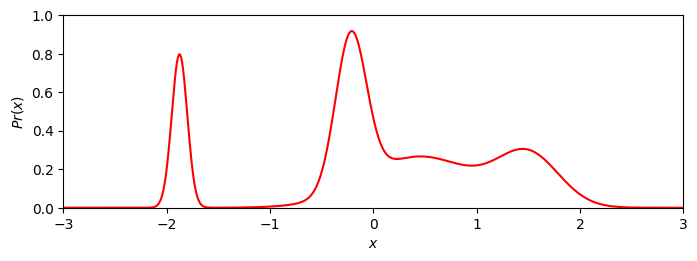

In [8]:
# Define ground truth probability distribution that we will model
true_dist = TrueDataDistribution()
# Let's visualize this
x_vals = np.arange(-3,3,0.01)
pr_x_true = true_dist.pdf(x_vals)
fig,ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.plot(x_vals, pr_x_true, 'r-')
ax.set_xlabel("$x$")
ax.set_ylabel("$Pr(x)$")
ax.set_ylim(0,1.0)
ax.set_xlim(-3,3)
plt.show()

To train the model to describe this distribution, we'll need to generate pairs of samples drawn from $Pr(z_t|x)$ (diffusion kernel) and $q(z_{t-1}|z_{t},x)$ (equation 18.15).



In [9]:
# Return z_t (the argument of g_{t}[] in the loss function in algorithm 18.1) and epsilon
def get_data_pairs(x_train,t,beta):

    epsilon = np.random.standard_normal(x_train.shape)
    alpha_t = np.power(1-beta,t)
    z_t = x_train * np.sqrt(alpha_t) + np.sqrt(1-alpha_t) * epsilon

    return z_t, epsilon

We also need models $\mbox{g}_t[z_{t},\phi_{t}]$ that map from $z_{t}$ to the noise $\epsilon$ that was added.  We're just going to use a very hacky non-parametric model (basically a lookup table) that tells you the result based on the (quantized) input.

In [19]:
# This code is really ugly!  Don't look too closely at it!
# All you need to know is that it is a model that trains from pairs zt, zt_minus1
# And can then predict zt
class NonParametricModel():
   # Constructor initializes parameters
  def __init__(self):

    self.inc = 0.01
    self.max_val = 3.0
    self.model = []

  # Learns a model that predicts epsilon given z_t
  def train(self, zt, epsilon):
      zt = np.clip(zt,-self.max_val,self.max_val)
      epsilon = np.clip(epsilon,-self.max_val,self.max_val)
      bins = np.arange(-self.max_val,self.max_val+self.inc,self.inc)
      numerator, *_ = stats.binned_statistic(zt, epsilon, statistic='sum',bins=bins)
      denominator, *_ = stats.binned_statistic(zt, epsilon, statistic='count',bins=bins)
      self.model = numerator / (denominator + 1)

  def predict(self, zt):
      bin_index = np.floor((zt+self.max_val)/self.inc)
      bin_index = np.clip(bin_index,0, len(self.model)-1).astype('uint32')
      return self.model[bin_index]

In [20]:
# Sample data from distribution (this would usually be our collected training set)
n_sample = 100000
x_train = true_dist.sample(n_sample)

# Define model parameters
T = 100
beta = 0.01511

all_models = []
for t in range(0,T):
    clear_output(wait=True)
    display("Training timestep %d"%(t))
    zt,epsilon= get_data_pairs(x_train,t,beta)
    all_models.append(NonParametricModel())
    # The model at index t maps data from z_{t+1} to epsilon
    all_models[t].train(zt,epsilon)

'Training timestep 99'

Now that we've learned the model, let's draw some samples from it.  We start at $z_{100}$ and use the model to predict $z_{99}$, then $z_{98}$ and so on until finally we get to $z_{1}$ and then $x$ (represented as $z_{0}$ here). We'll store all of the intermediate stages as well, so we can plot the trajectories.

This is the same model we learned last time.  The whole point of this is that it is compatible with any forward process with the same diffusion kernel.

One such model is the denoising diffusion implicit model, which has a sampling step:

\begin{equation}
\mathbf{z}_{t-1} = \sqrt{\alpha_{t-1}}\left(\frac{\mathbf{z}_{t}-\sqrt{1-\alpha_{t}}\mbox{g}_t[\mathbf{z}_{t},\boldsymbol\phi]}{\sqrt{\alpha_{t}}}\right) + \sqrt{1-\alpha_{t-1}-\sigma^2}\mbox{g}_t[\mathbf{z}_{t},\boldsymbol\phi]+\sigma\epsilon
\end{equation}

(see equation 12 of the denoising [diffusion implicit models paper ](https://arxiv.org/pdf/2010.02502.pdf).


In [21]:
def sample_ddim(model, T, sigma_t, n_samples):
    # Create the output array
    # Each row represents a time step, first row will be sampled data
    # Each column represents a different sample
    samples = np.zeros((T+1,n_samples))
    samples[T,:] = np.random.standard_normal(n_samples)

    # For t=100...99..98... ...0
    for t in range(T,0,-1):
        clear_output(wait=True)
        display("Predicting z_{%d} from z_{%d}"%(t-1,t))

        alpha_t = np.power(1-beta,t+1)
        alpha_t_minus1 = np.power(1-beta,t)

        # TODO -- implement the DDIM sampling step
        # Note the final noise term is already added in the "if" statement below
        # Replace this line:
        samples[t-1,:] = samples[t-1,:]

        # BEGIN_ANSWER
        epsilon_est = all_models[t-1].predict(samples[t,:])
        samples[t-1,:] = np.sqrt(alpha_t_minus1) * (samples[t,:] -np.sqrt(1-alpha_t) * epsilon_est)/np.sqrt(alpha_t) \
                                            + np.sqrt(1-alpha_t_minus1 - sigma_t*sigma_t) * epsilon_est
        # END_ANSWER

        # If not the last time step
        if t>0:
            samples[t-1,:] = samples[t-1,:]+ np.random.standard_normal(n_samples) * sigma_t
    return samples

Now let's run the diffusion process for a whole bunch of samples

'Predicting z_{0} from z_{1}'

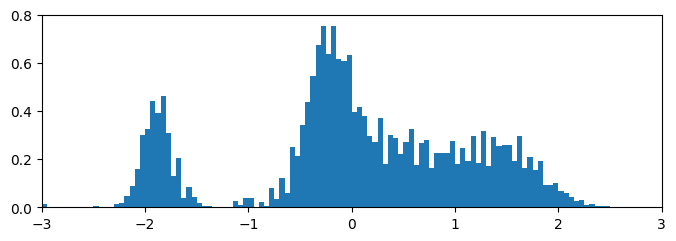

In [26]:
# Now we'll set the noise to a MUCH smaller level
sigma_t=0.001
n_samples = 100000
samples_low_noise = sample_ddim(all_models, T, sigma_t, n_samples)


# Plot the data
sampled_data = samples_low_noise[0,:]
bins = np.arange(-3,3.05,0.05)

fig,ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.set_xlim([-3,3])
plt.hist(sampled_data, bins=bins, density =True)
ax.set_ylim(0, 0.8)
plt.show()

Let's, plot the evolution of a few of the paths as in figure 18.7 (paths are from bottom to top now).

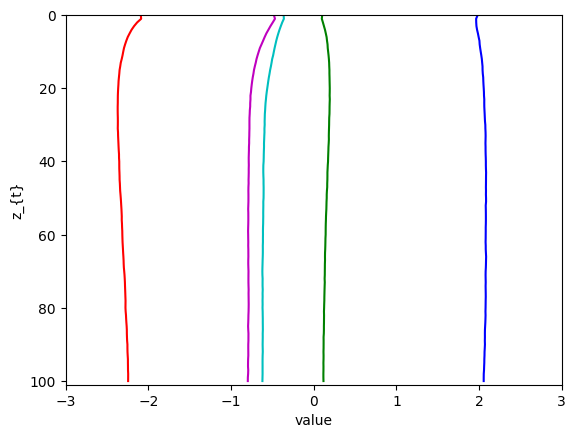

In [27]:
fig, ax = plt.subplots()
t_vals = np.arange(0,101,1)
ax.plot(samples_low_noise[:,0],t_vals,'r-')
ax.plot(samples_low_noise[:,1],t_vals,'g-')
ax.plot(samples_low_noise[:,2],t_vals,'b-')
ax.plot(samples_low_noise[:,3],t_vals,'c-')
ax.plot(samples_low_noise[:,4],t_vals,'m-')
ax.set_xlim([-3,3])
ax.set_ylim([101, 0])
ax.set_xlabel('value')
ax.set_ylabel('z_{t}')
plt.show()

The samples have a tendency to move from positions that are near the center at time 100 to positions that are high in the true probability distribution at time 0

Let's now sample from the accelerated model, that requires fewer models.  Again, we don't need to learn anything new -- this is just the reverse process that corresponds to a different forward process that is compatible with the same diffusion kernel.

There's nothing to do here except read the code.  It uses the same DDIM model as you just implemented in the previous step, but it jumps timesteps five at a time.

In [40]:
def sample_accelerated(model, T, sigma_t, n_steps, n_samples):
    # Create the output array
    # Each row represents a sample (i.e. fewer than the time steps), first row will be sampled data
    # Each column represents a different sample
    samples = np.zeros((n_steps+1,n_samples))
    samples[n_steps,:] = np.random.standard_normal(n_samples)

    # For each sampling step
    for c_step in range(n_steps,0,-1):
      # Find the corresponding time step and previous time step
      t= int(T * c_step/n_steps)
      tminus1 = int(T * (c_step-1)/n_steps)
      display("Predicting z_{%d} from z_{%d}"%(tminus1,t))

      alpha_t = np.power(1-beta,t+1)
      alpha_t_minus1 = np.power(1-beta,tminus1+1)
      epsilon_est = all_models[t-1].predict(samples[c_step,:])

      samples[c_step-1,:]=np.sqrt(alpha_t_minus1)*(samples[c_step,:]-np.sqrt(1-alpha_t) * epsilon_est)/np.sqrt(alpha_t) \
                                            + np.sqrt(1-alpha_t_minus1 - sigma_t*sigma_t) * epsilon_est
       # If not the last time step
      if t>0:
            samples[c_step-1,:] = samples[c_step-1,:]+ np.random.standard_normal(n_samples) * sigma_t
    return samples

Now let's draw a bunch of samples from the model

'Predicting z_{95} from z_{100}'

'Predicting z_{90} from z_{95}'

'Predicting z_{85} from z_{90}'

'Predicting z_{80} from z_{85}'

'Predicting z_{75} from z_{80}'

'Predicting z_{70} from z_{75}'

'Predicting z_{65} from z_{70}'

'Predicting z_{60} from z_{65}'

'Predicting z_{55} from z_{60}'

'Predicting z_{50} from z_{55}'

'Predicting z_{45} from z_{50}'

'Predicting z_{40} from z_{45}'

'Predicting z_{35} from z_{40}'

'Predicting z_{30} from z_{35}'

'Predicting z_{25} from z_{30}'

'Predicting z_{20} from z_{25}'

'Predicting z_{15} from z_{20}'

'Predicting z_{10} from z_{15}'

'Predicting z_{5} from z_{10}'

'Predicting z_{0} from z_{5}'

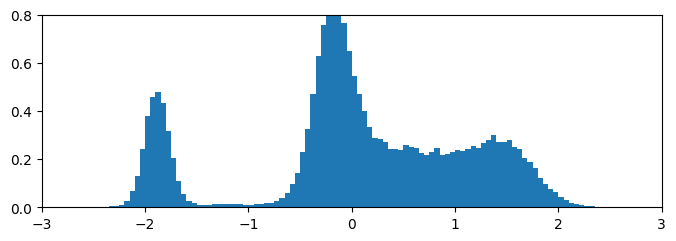

In [41]:
sigma_t=0.11
n_samples = 100000
n_steps = 20 # i.e. sample 5 times as fast as before -- should be a divisor of 100
samples_accelerated = sample_accelerated(all_models, T, sigma_t, n_steps, n_samples)


# Plot the data
sampled_data = samples_accelerated[0,:]
bins = np.arange(-3,3.05,0.05)

fig,ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.set_xlim([-3,3])
plt.hist(sampled_data, bins=bins, density =True)
ax.set_ylim(0, 0.8)
plt.show()

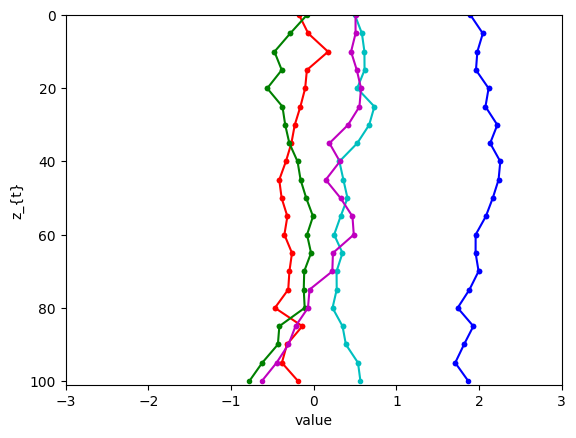

In [44]:
fig, ax = plt.subplots()
step_increment = 100/ n_steps
t_vals = np.arange(0,101,5)

for i in range(len(t_vals)-1):
  ax.plot( (samples_accelerated[i,0],samples_accelerated[i+1,0]), (t_vals[i], t_vals[i+1]),'r.-')
  ax.plot( (samples_accelerated[i,1],samples_accelerated[i+1,1]), (t_vals[i], t_vals[i+1]),'g.-')
  ax.plot( (samples_accelerated[i,2],samples_accelerated[i+1,2]), (t_vals[i], t_vals[i+1]),'b.-')
  ax.plot( (samples_accelerated[i,3],samples_accelerated[i+1,3]), (t_vals[i], t_vals[i+1]),'c.-')
  ax.plot( (samples_accelerated[i,4],samples_accelerated[i+1,4]), (t_vals[i], t_vals[i+1]),'m.-')

ax.set_xlim([-3,3])
ax.set_ylim([101, 0])
ax.set_xlabel('value')
ax.set_ylabel('z_{t}')
plt.show()